In [1]:
# import libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
# from qiskit_aer import AerSimulator
import qiskit
print(qiskit.__version__)
import matplotlib.pyplot as plt

1.3.1


In [2]:
# grid dim
grid = 3

# n data qubits
n_data = (grid ** 2)//2 + 1

# n syndrome qubits
n_syndrome = (grid ** 2) - n_data

In [3]:
n_data, n_syndrome

(5, 4)

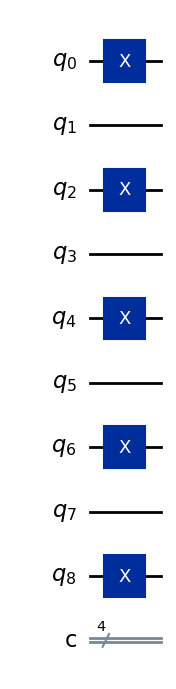

In [9]:
# Create a quantum circuit
qc = QuantumCircuit(n_data + n_syndrome, n_syndrome)

# appy not gate to recognize the data qubits which are in the even row
for i in range(grid**2):
    if i % 2 == 0:
        qc.x(i)
qc.draw(output='mpl')

In [10]:
# Create stabilizers
def apply_x_stabilizers(qc, grid):
    classical_bits = 0
    for i in range(grid):
        for j in range(grid):
            current = i * grid + j
            # if even row, z-syndrome (without Hadamards)
            if i % 2 == 0:
                if j % 2 == 1:
                    print("Applying Z stabilizers for qubit", current)
                    qc.cx(current, current - 1) # previuos qubit
                    qc.cx(current, current + 1) # next qubit
                    # if is the first row of the grid, then the qubit has connection with the qubit in the last row
                    if i != 0:
                        qc.cx(current, current - grid) # qubit above
                    if i != grid - 1:
                        qc.cx(current, current + grid) # qubit below
                    # measure the qubit onto the corresponding classical bit
                    qc.measure(current, classical_bits)
                    classical_bits += 1
                    qc.barrier()
            else:
                if j % 2 == 0:
                    print("Applying X stabilizers for qubit", current)
                    qc.h(current)
                    qc.cx(current, current + grid) # qubit below
                    qc.cx(current, current - grid) # qubit above
                    # if is the last row of the grid, then the qubit has connection with the qubit in the first row
                    if j != 0:
                        qc.cx(current, current - 1)
                    if j != grid - 1:
                        qc.cx(current, current + 1) # next qubit
                    qc.h(current)
                    qc.measure(current, classical_bits)
                    qc.barrier()
                    classical_bits += 1
                    

Applying Z stabilizers for qubit 1
Applying X stabilizers for qubit 3
Applying X stabilizers for qubit 5
Applying Z stabilizers for qubit 7


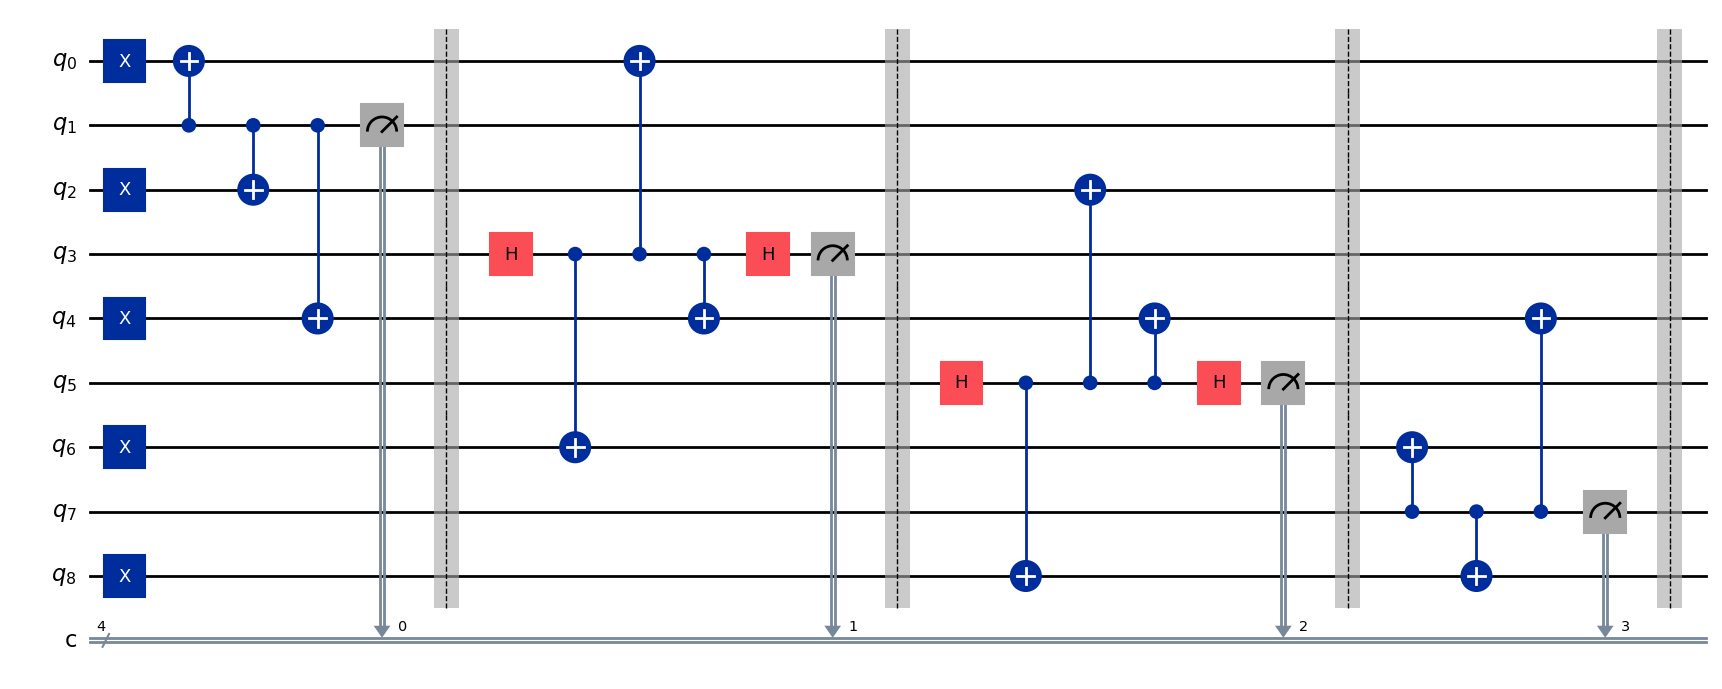

In [11]:
apply_x_stabilizers(qc, grid)
qc.draw(output='mpl')

In [49]:
# Define stabilizers
def apply_stabilizers(qc):
    # Example stabilizers for a 3x3 grid
    # Z-stabilizers (4 data qubits surrounding each Z-syndrome qubit)
    qc.cx(0, 9)  # Z-stabilizer involving data qubits 0, 1, 3, 4
    qc.cx(1, 9)
    qc.cx(3, 9)
    qc.cx(4, 9)
    qc.measure(9, 0)  # Measure Z-syndrome qubit 9
    qc.barrier()

    qc.cx(1, 10)  # Z-stabilizer involving data qubits 1, 2, 4, 5
    qc.cx(2, 10)
    qc.cx(4, 10)
    qc.cx(5, 10)
    qc.measure(10, 1)  # Measure Z-syndrome qubit 10
    qc.barrier()

    # X-stabilizers (similar to Z-stabilizers, but with Hadamard gates)
    qc.h(11)  # X-stabilizer for qubits 0, 1, 3, 4
    qc.cx(0, 11)
    qc.cx(1, 11)
    qc.cx(3, 11)
    qc.cx(4, 11)
    qc.h(11)
    qc.measure(11, 2)  # Measure X-syndrome qubit 11
    qc.barrier()

    qc.h(12)  # X-stabilizer for qubits 1, 2, 4, 5
    qc.cx(1, 12)
    qc.cx(2, 12)
    qc.cx(4, 12)
    qc.cx(5, 12)
    qc.h(12)
    qc.measure(12, 3)  # Measure X-syndrome qubit 12
    qc.barrier()
    return qc

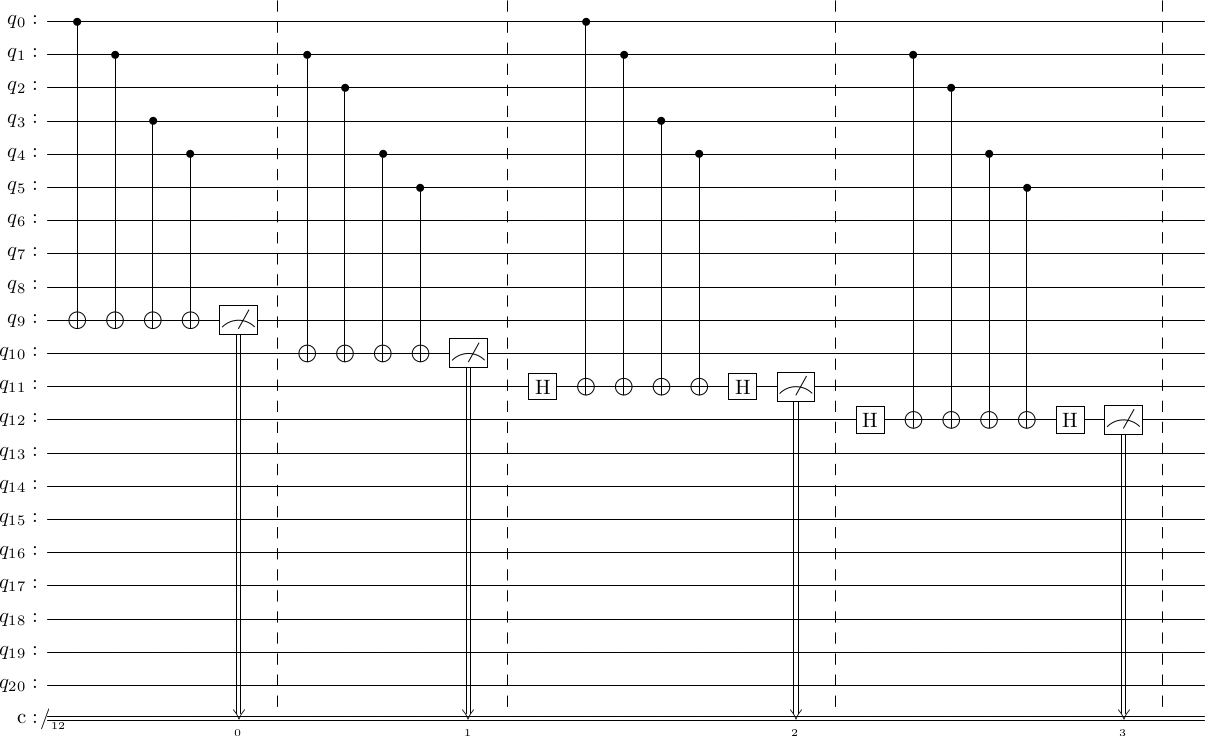

In [50]:
qc = apply_stabilizers(qc)
qc.draw(output='latex')

In [51]:
# Introduce an error
def introduce_error(qc):
    qc.x(4)  # Simulate a bit-flip error on data qubit 4
    return qc

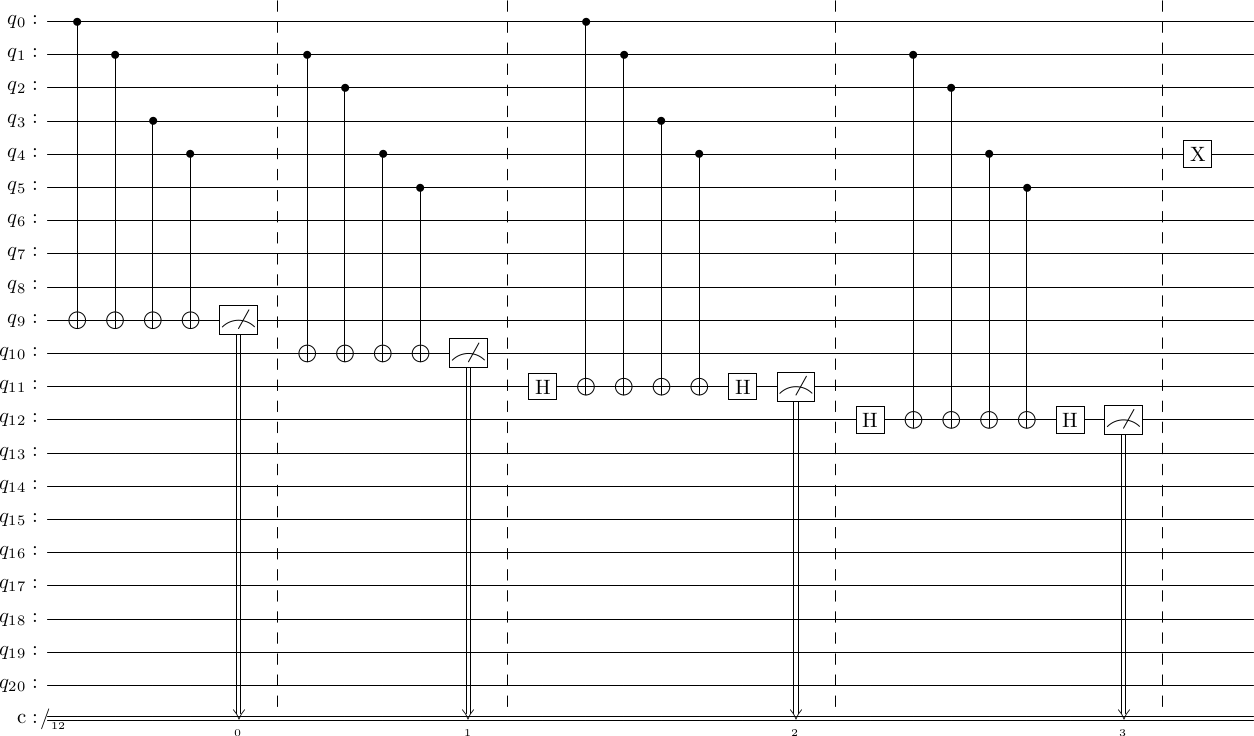

In [52]:
qc = introduce_error(qc)
qc.draw(output='latex')

In [53]:
# Apply correction based on syndrome measurements
def apply_correction(qc):
    # Example: Correct bit-flip error on data qubit 4 if detected by syndromes
    qc.x(4).c_if(qc.clbits[0], 1)  # Correction for Z-syndrome measurement 9
    qc.x(4).c_if(qc.clbits[1], 1)  # Correction for Z-syndrome measurement 10
    return qc

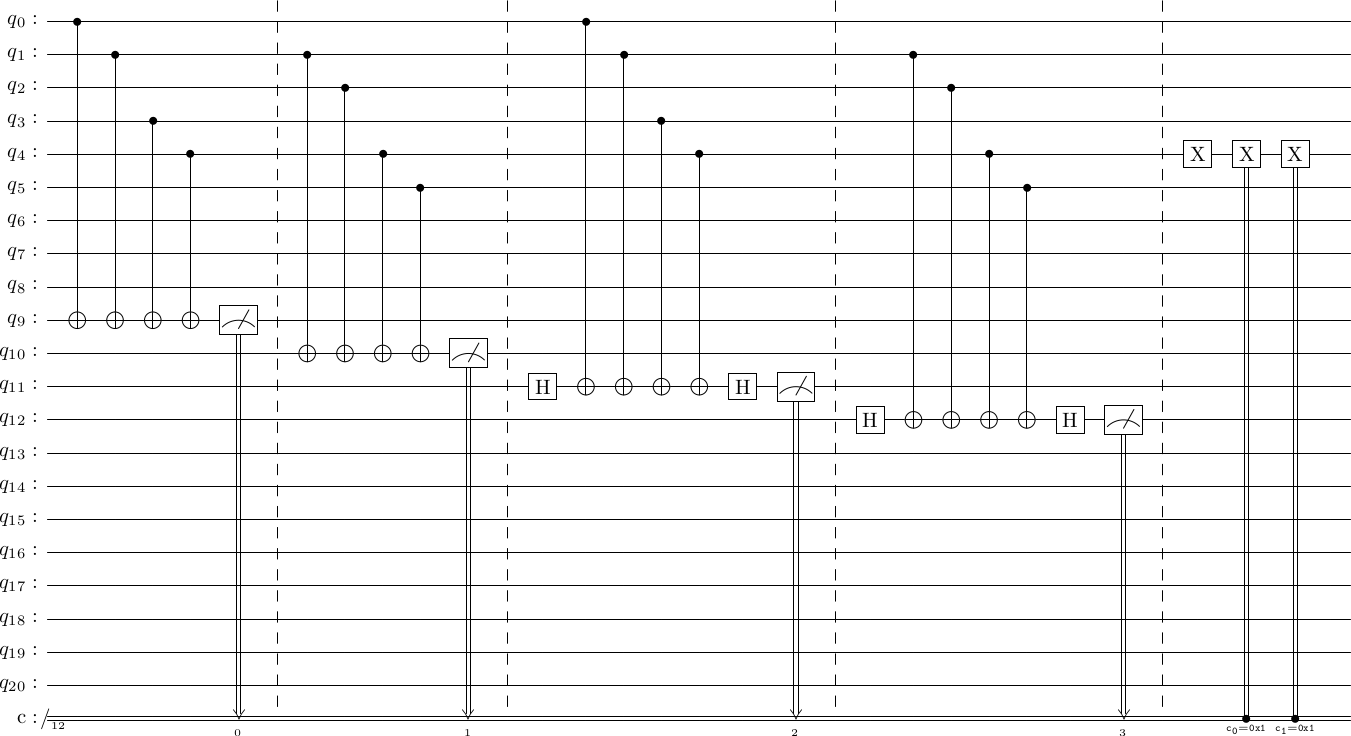

In [54]:
qc = apply_correction(qc)
qc.draw(output='latex')

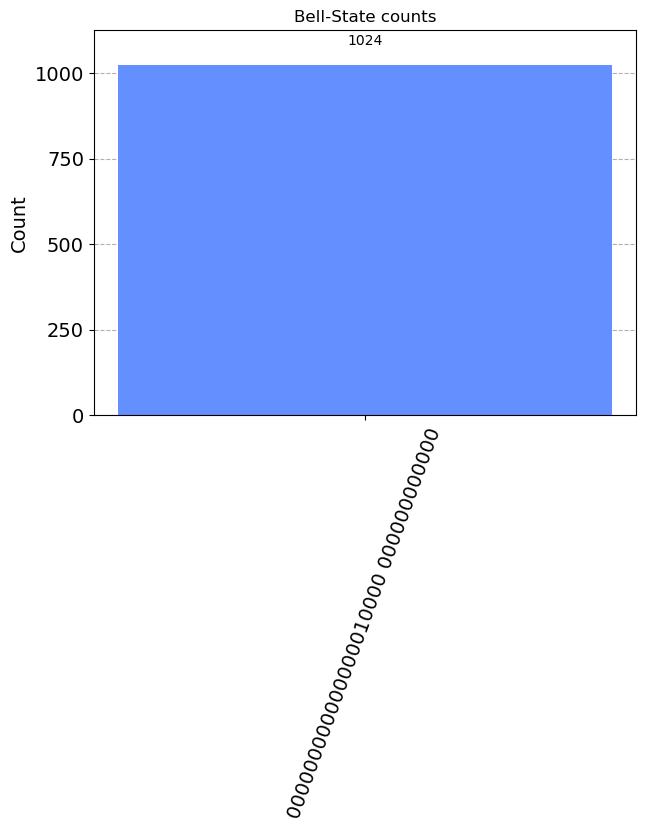

In [55]:
qc.measure_all()

# Simulate the circuit
simulator = AerSimulator()
circ = transpile(qc, simulator)
# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

In [31]:

job = execute(qc, simulator, shots=1024)
result = job.result()

# Retrieve and visualize the results
counts = result.get_counts()
print("Measurement outcomes:", counts)
plot_histogram(counts)


ImportError: cannot import name 'execute' from 'qiskit_aer' (/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/qiskit_aer/__init__.py)